# 🔐 RSA e ECC

Este notebook apresenta uma visão didática dos algoritmos criptográficos RSA e ECC, abordando desde a implementação básica do RSA do zero até o uso de bibliotecas modernas como `PyCryptodome` e `cryptography`.

Objetivos:

-  RSA com apenas operações matemáticas básicas.
- Demonstrar a vulnerabilidade de chaves pequenas no RSA.
- Mostrar implementações práticas de RSA e ECC com bibliotecas modernas.
- Comparar a performance entre RSA e ECC com benchmarks simples.


## 🧮 Seção 1 – Implementando RSA do Zero
Implementação completa do RSA com matemática básica: teste de primalidade, geração de chaves, criptografia e descriptografia.

### Gerando as chaves

#### Metodos

In [23]:
import random

def is_prime(n, k=5):
    """
    Testa se um número n é primo usando o Teste de Miller-Rabin.
    k é o número de iterações (quanto maior, mais preciso).
    """
    if n <= 1 or n == 4:
        return False
    if n <= 3:
        return True
    if n % 2 == 0:
        return False

    # Escreve n-1 como 2^s * d
    s = 0
    d = n - 1
    while d % 2 == 0:
        d //= 2
        s += 1

    for _ in range(k):
        a = random.randint(2, n - 2)
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(s - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True


def gerar_primo(bits):
    """Gera um número primo grande com um número específico de bits."""
    while True:
        num = random.getrandbits(bits)
        # Garante que o número tenha o número correto de bits e seja ímpar
        num |= (1 << bits - 1) | 1
        if is_prime(num):
            return num

O metodo `extended_gcd` é uma implmentação do algoritmo estendido de Euclides. Onde além de calcular o máximo divisor comum (MDC) entre dois números ( a ) e ( b ), também retorna dois inteiros ( x ) e ( y ) que satisfazem a identidade de Bézout.

- Caso base: se ( a = 0 ), então o MDC é ( b ), e os coeficientes de Bézout são ( x = 0 ) e ( y = 1 ).
- Recursão: calcula recursivamente o extended_gcd(b % a, a), ou seja, chama a si mesmo com os restos sucessivos.
- Volta recursiva: a cada retorno, ajusta os coeficientes ( x ) e ( y ) com base no valor anterior, usando a fórmula: 
    - $x = y_1 - \left\lfloor \frac{b}{a} \right\rfloor \cdot x_1$ 
    - $y = x_1$

A identidade de Bézout afirma que, dados dois números inteiros ( a ) e ( n ), existem inteiros ( x ) e ( y ) tais que $ax + ny = \gcd(a, n)$
- Quando ( $\gcd(a, n) = 1$ ), ou seja, ( a ) e ( n ) são coprimos, essa equação mostra que é possível encontrar um ( x ) tal que ( $ax \equiv 1 \pmod{n}$ )
- Esse valor de ( x ) é justamente o inverso modular de ( a ) módulo ( n )

Assim, a identidade de Bézout é utilizado para calcular o inverso modular de números (primos), importantes para o algoritmo RSA.




In [24]:
def gcd(a, b):
    """Calcula o Maior Divisor Comum (MDC) de a e b usando o algoritmo de Euclides."""
    while b:
        a, b = b, a % b
    return a

def extended_gcd(a, b):
    """
    Calcula o MDC de a e b e coeficientes x, y tais que ax + by = gcd(a, b).
    Retorna (gcd, x, y).
    """
    if a == 0:
        return b, 0, 1
    else:
        g, x, y = extended_gcd(b % a, a)
        return g, y - (b // a) * x, x

def mod_inverse(a, m):
    """
    Calcula o inverso modular de a modulo m, se existir.
    Ou seja, encontra x tal que (a * x) % m == 1.
    """
    g, x, y = extended_gcd(a, m)
    if g != 1:
        raise Exception('O inverso modular não existe')
    else:
        return x % m

#### gerar chaves

In [25]:
def gerar_chaves_rsa(bits=1024,debug=False):
    """
    Gera um par de chaves RSA (chave pública e chave privada).
    bits: O tamanho em bits dos números primos p e q (determina a segurança).
    """
    print("Gerando números primos p e q...")
    p = gerar_primo(bits)
    q = gerar_primo(bits)

    while p == q: # Garante que p e q sejam diferentes
        q = gerar_primo(bits)

    n = p * q
    phi = (p - 1) * (q - 1) # Função totiente de Euler

    if debug:
        print(f"p: {p}")
        print(f"q: {q}")
        print(f"n (módulo): {n}")
        print(f"phi(n): {phi}")

    # Escolhe 'e' (expoente público), coprimo com phi
    e = random.randrange(1, phi)
    while gcd(e, phi) != 1:
        e = random.randrange(1, phi)

    # Calcula 'd' (expoente privado), inverso modular de e modulo phi
    d = mod_inverse(e, phi)

    # Chave pública: (e, n)
    # Chave privada: (d, n)
    return ((e, n), (d, n))

### Metodos de Criptografar e Descriptografia

In [26]:
def encrypt(public_key, plaintext):
    """
    Criptografa o texto plano usando a chave pública.
    C = M^e mod n
    """
    e, n = public_key
    # Converte cada caractere para seu valor ASCII e criptografa
    cipher = [pow(ord(char), e, n) for char in plaintext]
    return cipher

def decrypt(private_key, ciphertext):
    """
    Descriptografa o texto cifrado usando a chave privada.
    M = C^d mod n
    """
    d, n = private_key
    # Descriptografa cada número e converte de volta para caractere
    plain = [chr(pow(char, d, n)) for char in ciphertext]
    return "".join(plain)

### Cifrando e Decifrando

gerando as chaves

In [27]:
pub, priv = gerar_chaves_rsa(512)
print("🔐 Chave pública:", pub)
print("🔑 Chave privada:", priv)

Gerando números primos p e q...
🔐 Chave pública: (110738874208567711707689016040389020210356976846577785250151466281947118540770852809407296914437681954111393873132089721377547415638752630966044021808950240821352155988392584471829934892530670358448323395155814196847492453814359346851214259003075923158183638368931894316336622866413253099367638762225008029911, 132269051718006956383541817750699470071736788605958280513907923242237654103291834529670319893937436043977425629385941386477308847655469610374573412449556443509101424755314818945816102904069960279359119519272953027833941138886124378633602923861580087030895208914510796567176068861274253294065421165442109607801)
🔑 Chave privada: (99441758934836608039763918228982895910083004416685544567832315074633722410185246740649291372669917492205772088562295854502757262779692556541111718416444430523127938951506713146340881009706747437533050979958891041984884126226416192090006684857193409143488976188594337521905398557339239281122554514937177745535, 

criptografar

In [28]:
message = "Olá, este é um teste de criptografia RSA!"
print(f"\nMensagem Original: {message}")

# Criptografia
print("\nCriptografando mensagem...")
encrypted_message = encrypt(pub, message)
print("🔒 Criptografada:", encrypted_message)


Mensagem Original: Olá, este é um teste de criptografia RSA!

Criptografando mensagem...
🔒 Criptografada: [38679865273625048937493886318617896537958726950598601582077566684314270606082835824130676390126093144259042616479909170564707067029216615589920569806992757824634354120827802929626409220765919117162054168453997935371586533905989866179095781370489071672891986366915104447955817279876247495666851963492197991539, 107711435552558876077190490347122257275081047642350256157399861665744632528679561265935173479462839396646998252451581513841678148685446565810999634415405807019259132554944673944859611609418991627911252744138763421496580887716868092411819386239766284152845027422564023420606119429816142574218528391677754153038, 5133834786352936918759566238839333659685306421728359857716682664528557427574779819889987305864781191658232811997463981239961627552136958688570311102639097772030411452849967549012652982791074030966942918537626399503628761416973669230777603396539720943987972352868577731202

descriptografar

In [29]:
# Descriptografia
print("\nDescriptografando mensagem...")
decrypted_message = decrypt(priv, encrypted_message)
print("🔓 Descriptografada:", decrypted_message)


Descriptografando mensagem...
🔓 Descriptografada: Olá, este é um teste de criptografia RSA!


### Alterando os parametros

In [30]:
pub, priv = gerar_chaves_rsa(8)

Gerando números primos p e q...


In [31]:
print("Gerando par de chaves RSA...")
message = """
Os loucos por amor eram três ou quatro, mas só dous espantavam pelo curioso do delírio. O primeiro, um Falcão, rapaz de vinte e cinco anos, supunha-se estrela d'alva, abria os braços e alargava as pernas, para dar-lhes certa feição de raios, e ficava assim horas esquecidas a perguntar se o sol já tinha saído para ele recolher-se. O outro andava sempre, sempre, sempre, à roda das salas ou do pátio, ao longo dos corredores, à procura do fim do mundo. Era um desgraçado, a quem a mulher deixou por seguir um peralvilho. Mal descobrira a fuga, armou-se de uma garrucha, e saiu-lhes no encalço; achou-os duas horas depois, ao pé de uma lagoa, matou-os a ambos com os maiores requintes de crueldade.
 O ciúme satisfez-se, mas o vingado estava louco. E então começou aquela ânsia de ir ao fim do mundo à cata dos fugitivos.

A mania das grandezas tinha exemplares notáveis. O mais notável era um pobre-diabo, filho de um algibebe, que narrava às paredes (porque não olhava nunca para nenhuma pessoa) toda a sua genealogia, que era esta:

- Deus engendrou um ovo, o ovo engendrou a espada, a espada engendrou Davi, Davi engendrou a púrpura, a púrpura engendrou o duque, o duque engendrou o marquês, o marquês engendrou o conde, que sou eu.

Dava uma pancada na testa, um estalo com os dedos, e repetia cinco, seis vezes seguidas:

- Deus engendrou um ovo, o ovo, etc.

Outro da mesma espécie era um escrivão, que se vendia por mordomo do rei; outro era um boiadeiro de Minas, cuja mania era distribuir boiadas a toda a gente, dava trezentas cabeças a um, seiscentas a outro, mil e duzentas a outro, e não acabava mais. Não falo dos casos de monomania religiosa; apenas citarei um sujeito que, chamando-se João de Deus, dizia agora ser o deus João, e prometia o reino dos céus a quem o adorasse, e as penas do inferno aos outros; e depois desse, o licenciado Garcia, que não dizia nada, porque imaginava que no dia em que chegasse a proferir uma só palavra, todas as estrelas se despegariam do céu e abrasariam a terra; tal era o poder que recebera de Deus. Assim o escrevia ele no papel que o alienista lhe mandava dar, menos por caridade do que por interesse científico.

Que, na verdade, a paciência do alienista era ainda mais extraordinária do que todas as manias hospedadas na Casa Verde; nada menos que assombrosa. Simão Bacamarte começou por organizar um pessoal de administração; e, aceitando essa ideia ao boticário Crispim Soares, aceitou-lhe também dous sobrinhos, a quem incumbiu da execução de um regimento que lhes deu, aprovado pela Câmara, da distribuição da comida e da roupa, e assim também da escrita, etc. Era o melhor que podia fazer, para somente cuidar do seu ofício.
"""


encrypted_message = encrypt(pub, message)
decrypted_message = decrypt(priv, encrypted_message)
print("🔓 Descriptografada:", decrypted_message)


Gerando par de chaves RSA...
🔓 Descriptografada: 
Os loucos por amor eram três ou quatro, mas só dous espantavam pelo curioso do delírio. O primeiro, um Falcão, rapaz de vinte e cinco anos, supunha-se estrela d'alva, abria os braços e alargava as pernas, para dar-lhes certa feição de raios, e ficava assim horas esquecidas a perguntar se o sol já tinha saído para ele recolher-se. O outro andava sempre, sempre, sempre, à roda das salas ou do pátio, ao longo dos corredores, à procura do fim do mundo. Era um desgraçado, a quem a mulher deixou por seguir um peralvilho. Mal descobrira a fuga, armou-se de uma garrucha, e saiu-lhes no encalço; achou-os duas horas depois, ao pé de uma lagoa, matou-os a ambos com os maiores requintes de crueldade.
 O ciúme satisfez-se, mas o vingado estava louco. E então começou aquela ânsia de ir ao fim do mundo à cata dos fugitivos.

A mania das grandezas tinha exemplares notáveis. O mais notável era um pobre-diabo, filho de um algibebe, que narrava às paredes

## 🧩 Seção 2 – Implementações com Bibliotecas Python
Nesta seção, vamos explorar o uso de bibliotecas modernas para implementar criptografia RSA e ECC na prática.

### 🔍 RSA com PyCryptodome

In [32]:
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Signature import pkcs1_15
from Crypto.Hash import SHA256


#### 🔭 Criptografia de Desciptografia

In [33]:
# Geração de chave RSA
key = RSA.generate(2048)
public_key = key.publickey()

message = b"Mensagem com PyCryptodome"

# Criptografia
cipher = PKCS1_OAEP.new(public_key)
ciphertext = cipher.encrypt(message)
print("🔒 Criptografado:", ciphertext.hex())


🔒 Criptografado: 66c243686927519176c58fd7bb78a7a59b859de916482b058a2c0e86e8e1c76308d36f3642c12df8647acb571b0d397f09c370933d2aa3cb9749d68065582c9cf8bc11358b539a4bff5762b24d2d5eb75b4c90b902dc8de68c09284dd85684be61e7f957916d508194febec2ff022e0ff3ccb9900910d219ccb071a9f72b7cff0cb85155dfcae3bd114b32e380ea37577ffc87d42dc85866f67935738f9f1283f95196e8d83483f6a0e9c47cf10c26606eb02e04e067f103c005bdfe641429e1c0228b79625c35e52310b9f68fa8c7a44f78421bf52dc94eb34b917cc788a0a5e28210aa3ad4efeffa9ea0bd4d68626e5c8ca7b1d1b87a63ab6d351314b6b4fd


In [34]:
# Descriptografia
decipher = PKCS1_OAEP.new(key)
plaintext = decipher.decrypt(ciphertext)
print("🔓 Descriptografado:", plaintext.decode())

🔓 Descriptografado: Mensagem com PyCryptodome


### 🪢 ECC com `cryptography` (Ed25519)


O algoritmo Ed25519 é uma curva elíptica com suporte na biblioteca `cryptography`.

In [35]:
from cryptography.hazmat.primitives.asymmetric import ed25519

In [36]:
# Geração de chave
private_key = ed25519.Ed25519PrivateKey.generate()
public_key = private_key.public_key()


In [37]:
# Assinatura de mensagem
msg = b"Mensagem assinada com Ed25519"
signature = private_key.sign(msg)

In [38]:
# Verificação
public_key.verify(signature, msg)

#### 📌 Exibindo as chaves Ed25519

In [39]:
from cryptography.hazmat.primitives import serialization

In [40]:
# Obter bytes "puros" da chave privada (seed de 32 bytes)
private_bytes = private_key.private_bytes(
    encoding=serialization.Encoding.Raw,
    format=serialization.PrivateFormat.Raw,
    encryption_algorithm=serialization.NoEncryption()
)

# Obter bytes da chave pública
public_bytes = public_key.public_bytes(
    encoding=serialization.Encoding.Raw,
    format=serialization.PublicFormat.Raw
)

In [41]:
print(f"\n📏 Tamanhos: chave privada = {len(private_bytes)} bytes, pública = {len(public_bytes)} bytes")


📏 Tamanhos: chave privada = 32 bytes, pública = 32 bytes


In [42]:
print("🔐 Escalar da chave privada (d, 32 bytes):")
print(private_bytes.hex())


🔐 Escalar da chave privada (d, 32 bytes):
8cc300665a65718cfd1f351ed53507b64bb7158e80e40ca70d38fceafa0a693b


In [43]:
print("\n📌 Coordenadas compactadas da chave pública (A = d*B, 32 bytes):")
print(public_bytes.hex())


📌 Coordenadas compactadas da chave pública (A = d*B, 32 bytes):
5dbd7011e39f39711ba6a02d318e7856c39348e70eef249cb9e01fc8ea4cff69


## ⏱️ Seção 3 – Comparação de Desempenho: RSA Didático vs PyCryptodome vs ECC

Vamos comparar o desempenho de três abordagens de criptografia:

1. RSA implementado do zero (versão didática)
2. RSA com a biblioteca `PyCryptodome`
3. ECC (Ed25519) com a biblioteca `cryptography`

Faremos os testes com diferentes tamanhos de mensagens e chaves e mediremos:

- Tempo de criptografia e descriptografia
- Uso de memória

In [44]:
import time
import matplotlib.pyplot as plt
import tracemalloc
import numpy as np

def measure_time_memory(func, *args):
    tracemalloc.start()
    start_time = time.perf_counter()
    result = func(*args)
    end_time = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return end_time - start_time, peak / 1024, result

def measure_time_memory_2(func, msg , key):
    tracemalloc.start()
    start_time = time.perf_counter()
    result = func(key,msg)
    end_time = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return end_time - start_time, peak / 1024, result

# Mensagens de diferentes tamanhos
messages = {
    'curta': "abc",
    'média': "mensagem de teste com tamanho médio",
    'longa': "X" * 100
}

# RSA didático
rsa_keys_512 = gerar_chaves_rsa(512)
rsa_keys_1024 = gerar_chaves_rsa(1024)

# PyCryptodome
from Crypto.PublicKey import RSA as RSACrypto
from Crypto.Cipher import PKCS1_OAEP
pycrypto_key = RSACrypto.generate(2048)
pycrypto_enc = PKCS1_OAEP.new(pycrypto_key.publickey())
pycrypto_dec = PKCS1_OAEP.new(pycrypto_key)

# ECC (Ed25519)
from cryptography.hazmat.primitives.asymmetric import ed25519
ecc_key = ed25519.Ed25519PrivateKey.generate()
ecc_pub = ecc_key.public_key()

tempos = {'RSA_didático_512': [], 'RSA_didático_1024': [], 'PyCryptodome_RSA_2048': [], 'ECC_ed25519': []}
memorias = {'RSA_didático_512': [], 'RSA_didático_1024': [], 'PyCryptodome_RSA_2048': [], 'ECC_ed25519': []}



Gerando números primos p e q...
Gerando números primos p e q...


In [46]:
for nome, texto in messages.items():
    bmsg = texto.encode()

    # RSA Caseiro 512
    priv = rsa_keys_512[0]
    pub = rsa_keys_512[1]
    t1, m1, c = measure_time_memory_2(encrypt, texto, priv)
    t2, m2, _ = measure_time_memory_2(decrypt, c, pub)
    tempos['RSA_didático_512'].append(t1 + t2)
    memorias['RSA_didático_512'].append(m1 + m2)

    # RSA Caseiro 1024
    t1, m1, c = measure_time_memory_2(encrypt, texto, rsa_keys_1024[0])
    t2, m2, _ = measure_time_memory_2(decrypt, c, rsa_keys_1024[1])
    tempos['RSA_didático_1024'].append(t1 + t2)
    memorias['RSA_didático_1024'].append(m1 + m2)

    # RSA PyCryptodome
    t1, m1, c = measure_time_memory(pycrypto_enc.encrypt, bmsg)
    t2, m2, _ = measure_time_memory(pycrypto_dec.decrypt, c)
    tempos['PyCryptodome_RSA_2048'].append(t1 + t2)
    memorias['PyCryptodome_RSA_2048'].append(m1 + m2)

    # ECC Ed25519 (assinatura/verificação)
    t1, m1, s = measure_time_memory(ecc_key.sign, bmsg)
    t2, m2, _ = measure_time_memory(ecc_pub.verify, s, bmsg)
    tempos['ECC_ed25519'].append(t1 + t2)
    memorias['ECC_ed25519'].append(m1 + m2)


plotando

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Títulos das mensagens
labels = list(messages.keys())
x = np.arange(len(labels))
bar_width = 0.15

algoritmos = list(tempos.keys())

In [48]:
colors = plt.cm.tab20.colors[:len(algoritmos)]

def plot_barras(metricas, ylabel, titulo):
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (alg, valores) in enumerate(metricas.items()):
        valores = valores[:len(x)]  
        y_vals = [valores[j] if j < len(valores) else 0 for j in range(len(x))]
        bar_x = x + i * bar_width

        bars = ax.bar(bar_x, y_vals, bar_width, label=alg, color=colors[i % len(colors)])

        for rect in bars:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    
    ax.set_ylabel(ylabel)
    ax.set_title(titulo)
    ax.set_xticks(x + bar_width * (len(algoritmos) - 1) / 2)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

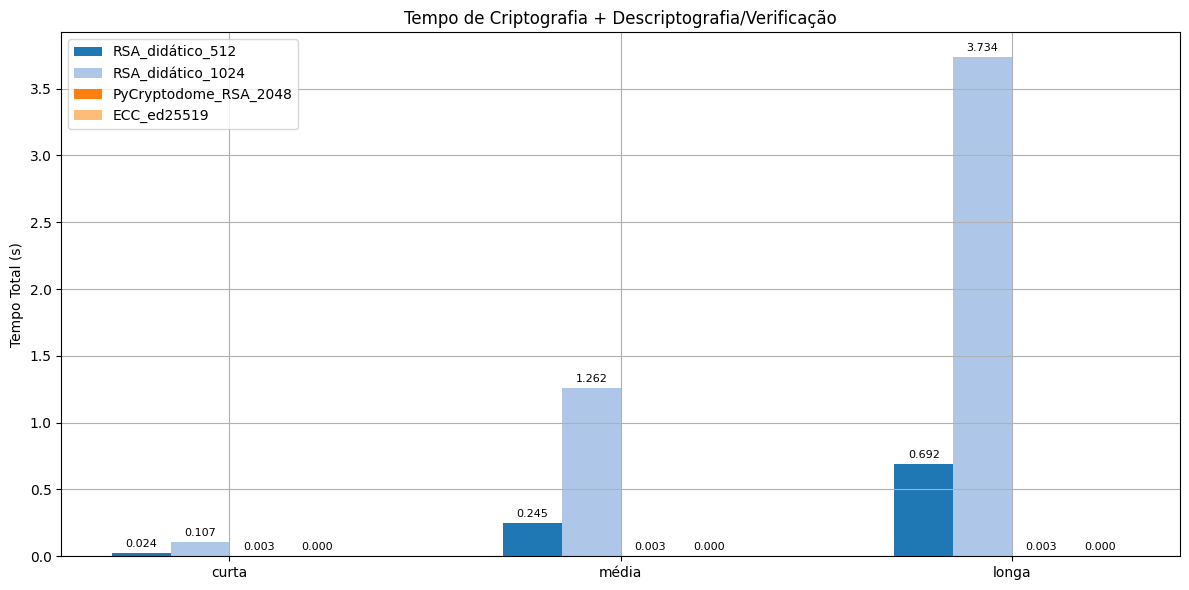

In [49]:
plot_barras(tempos, "Tempo Total (s)", "Tempo de Criptografia + Descriptografia/Verificação")

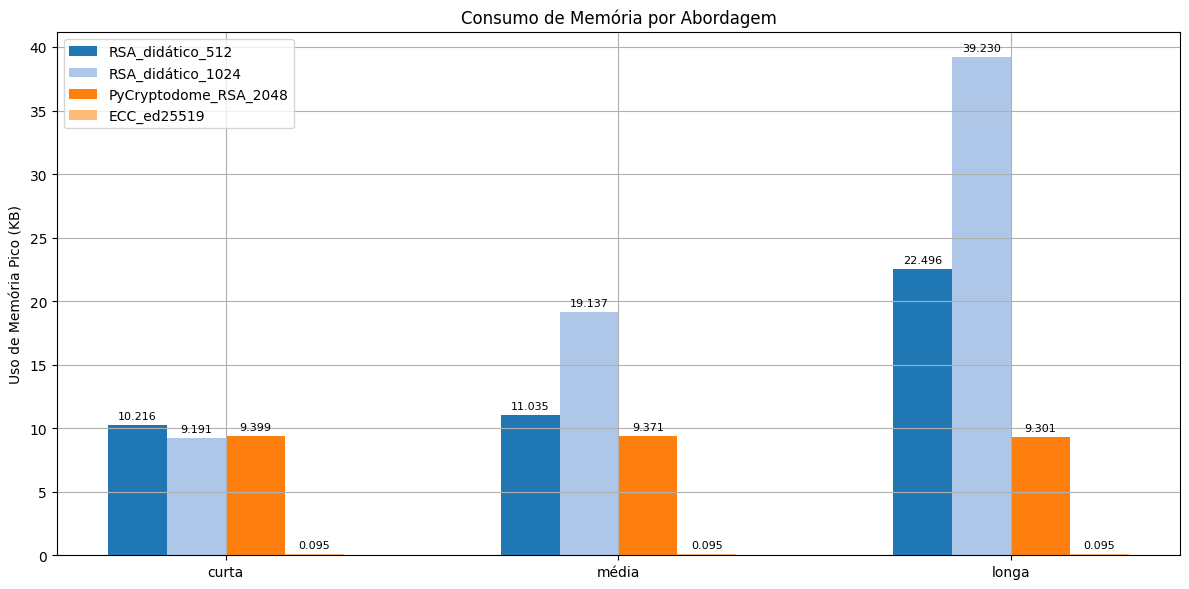

In [50]:
plot_barras(memorias, "Uso de Memória Pico (KB)", "Consumo de Memória por Abordagem")